# LSTM with Memory Between Batches

Reference: https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/

In [1]:
import numpy
from numpy import concatenate
import math
from math import sqrt

import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import matplotlib
matplotlib.use('Agg')

from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [5]:
# Apple file path
eur = pd.read_csv("/Users/john/Desktop/eurv1.csv", parse_dates=['time'], index_col=['time'], 
                  usecols= ['OpenMid', 'HighMid', 'LowMid', 'CloseMid', 'lowBid','highAsk','volume', 'time'])

# Windows file path
#eur = pd.read_csv("C:/Users/jkyvetos/Desktop/EURUSD volatility analysis/eurv1.csv", parse_dates=['time'], index_col=['time'], 
#                  usecols= ['OpenMid', 'HighMid', 'LowMid', 'CloseMid', 'lowBid','highAsk','volume', 'time'])

eur1d = eur.resample('1D').agg({'OpenMid': 'first', 
                       'HighMid': 'max', 
                        'LowMid': 'min', 
                      'CloseMid': 'last',
                       'lowBid' : 'min',
                      'highAsk' : 'max',
                       'volume' : 'sum'})

eur1d.dropna(inplace=True)
#eur1d.fillna(method='ffill', inplace=True)

eur1d['Volatility'] = eur1d['highAsk'] - eur1d['lowBid']
dataset = eur1d['Volatility'].to_frame()
dataset = dataset.astype('float32')
dataset = dataset[1:]
print(len(dataset))
print(eur1d.head(3))
print(dataset.head(3))

1143
             OpenMid   HighMid    LowMid  CloseMid   lowBid  highAsk  \
time                                                                   
2014-01-01  1.375250  1.377385  1.374245  1.376425  1.37353  1.37757   
2014-01-02  1.376435  1.377565  1.362960  1.366535  1.36290  1.37769   
2014-01-03  1.366535  1.367205  1.358250  1.358885  1.35818  1.36727   

              volume  Volatility  
time                              
2014-01-01    5106.0     0.00404  
2014-01-02  102368.0     0.01479  
2014-01-03   68106.0     0.00909  
            Volatility
time                  
2014-01-02     0.01479
2014-01-03     0.00909
2014-01-05     0.00138


0) TrainRMSE=0.012656, TestRMSE=0.012009
1) TrainRMSE=0.012650, TestRMSE=0.011710
2) TrainRMSE=0.012485, TestRMSE=0.011620
3) TrainRMSE=0.012468, TestRMSE=0.012022
4) TrainRMSE=0.012578, TestRMSE=0.012008


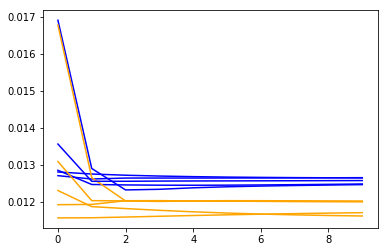

In [5]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1, dropnan=True):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df 
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # separate
    X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
    # reshape
    reshaped = X.reshape(len(X), 1, 1)
    # forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        # invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # invert differencing
        yhat = yhat + raw_data[i]
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    return rmse
 
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        model.reset_states()
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history
 
# run diagnostic experiments
def run():
    series = dataset
    raw_values = series.values
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(raw_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-540], supervised_values[-540:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 5
    n_batch = 1
    n_epochs = 10
    n_neurons = 1
    # run diagnostic tests
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('epochs_diagnostic.png')

# entry point
run()

# Tuning parameters, first with epoch

1) Test RMSE: 0.00499
2) Test RMSE: 0.00503
3) Test RMSE: 0.00501
4) Test RMSE: 0.00494
5) Test RMSE: 0.00503
1) Test RMSE: 0.00511
2) Test RMSE: 0.00497
3) Test RMSE: 0.00501
4) Test RMSE: 0.00498
5) Test RMSE: 0.00503
1) Test RMSE: 0.00504
2) Test RMSE: 0.00508
3) Test RMSE: 0.00478
4) Test RMSE: 0.00512
5) Test RMSE: 0.00517
1) Test RMSE: 0.00499
2) Test RMSE: 0.00509
3) Test RMSE: 0.00506
4) Test RMSE: 0.00505
5) Test RMSE: 0.00503
1) Test RMSE: 0.00509
2) Test RMSE: 0.00508
3) Test RMSE: 0.00514
4) Test RMSE: 0.00514
5) Test RMSE: 0.00509
1) Test RMSE: 0.00511
2) Test RMSE: 0.00513
3) Test RMSE: 0.00516
4) Test RMSE: 0.00515
5) Test RMSE: 0.00510
1) Test RMSE: 0.00513
2) Test RMSE: 0.00512
3) Test RMSE: 0.00512
4) Test RMSE: 0.00513
5) Test RMSE: 0.00514
             20        30        40        50       100       150       200
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.005002  0.005019  0.005039  0.005044  0.005108  0.005128  0.005129
st

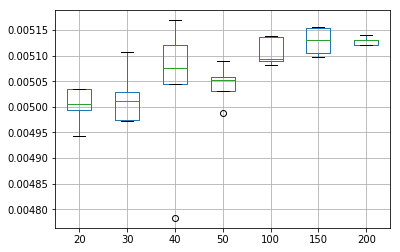

In [92]:
# run a repeated experiment
def experiment(repeats, series, epochs):
    series = dataset
    raw_values = series.values
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(raw_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-540], supervised_values[-540:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 1
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
        # forecast the entire training dataset to build up state for forecasting
        train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
        lstm_model.predict(train_reshaped, batch_size=batch_size)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-540:], predictions))
        print('%d) Test RMSE: %.5f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# load dataset
series = dataset
# experiment
repeats = 5
n_batch = 1
n_neurons = 1

results = pd.DataFrame()
# vary training epochs
epochs = [20, 30, 40, 50, 100, 150, 200]
for e in epochs:
    results[str(e)] = experiment(repeats, series, e)

# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

In [94]:
# Epoch 20 is the best, i will keep this

# Tune Batch Size

In [56]:
# run a repeated experiment
def experiment(repeats, series, batch_size):
    series = dataset
    raw_values = series.values
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(raw_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-540], supervised_values[-540:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, batch_size, 20, 1)
        # forecast the entire training dataset to build up state for forecasting
        train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
        lstm_model.predict(train_reshaped, batch_size=batch_size)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=batch_size)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-540:], predictions))
        print('%d) Test RMSE: %.5f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores


1) Test RMSE: 0.00510
2) Test RMSE: 0.00520
3) Test RMSE: 0.00518
4) Test RMSE: 0.00500
5) Test RMSE: 0.00498
1) Test RMSE: 0.00507
2) Test RMSE: 0.00508
3) Test RMSE: 0.00508
4) Test RMSE: 0.00507
5) Test RMSE: 0.00504
1) Test RMSE: 0.00499
2) Test RMSE: 0.00503
3) Test RMSE: 0.00507
4) Test RMSE: 0.00498
5) Test RMSE: 0.00497
1) Test RMSE: 0.00494
2) Test RMSE: 0.00485
3) Test RMSE: 0.00490
4) Test RMSE: 0.00490
5) Test RMSE: 0.00485
              2         4         6        10
count  5.000000  5.000000  5.000000  5.000000
mean   0.005090  0.005068  0.005011  0.004888
std    0.000103  0.000017  0.000040  0.000037
min    0.004978  0.005040  0.004975  0.004850
25%    0.004996  0.005071  0.004984  0.004853
50%    0.005096  0.005072  0.004991  0.004898
75%    0.005180  0.005078  0.005034  0.004900
max    0.005203  0.005082  0.005071  0.004938


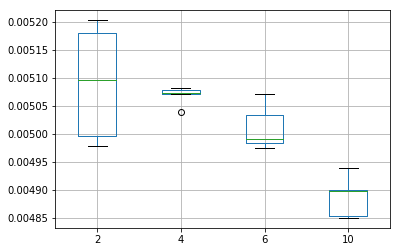

In [62]:
# load dataset
series = dataset
# experiment
repeats = 5
results = DataFrame()
# vary training batches
batches = [2, 4, 6, 10]
for b in batches:
    results[str(b)] = experiment(repeats, series, b)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_batches.png')

In [13]:
# 10 batch size the best and much better than  1

# Tune Neurons

1) Test RMSE: 0.00502
2) Test RMSE: 0.00488
3) Test RMSE: 0.00480
4) Test RMSE: 0.00481
5) Test RMSE: 0.00508
1) Test RMSE: 0.00501
2) Test RMSE: 0.00491
3) Test RMSE: 0.00491
4) Test RMSE: 0.00496
5) Test RMSE: 0.00492
1) Test RMSE: 0.00493
2) Test RMSE: 0.00497
3) Test RMSE: 0.00494
4) Test RMSE: 0.00487
5) Test RMSE: 0.00495
1) Test RMSE: 0.00487
2) Test RMSE: 0.00496
3) Test RMSE: 0.00493
4) Test RMSE: 0.00493
5) Test RMSE: 0.00492
1) Test RMSE: 0.00510
2) Test RMSE: 0.00496
3) Test RMSE: 0.00491
4) Test RMSE: 0.00507
5) Test RMSE: 0.00511
1) Test RMSE: 0.00515
2) Test RMSE: 0.00513
3) Test RMSE: 0.00509
4) Test RMSE: 0.00516
5) Test RMSE: 0.00520
              1         2         3         4         5        10
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000
mean   0.004920  0.004942  0.004931  0.004921  0.005030  0.005146
std    0.000125  0.000041  0.000038  0.000031  0.000087  0.000041
min    0.004804  0.004909  0.004869  0.004873  0.004915  0.005088
25%    0.0

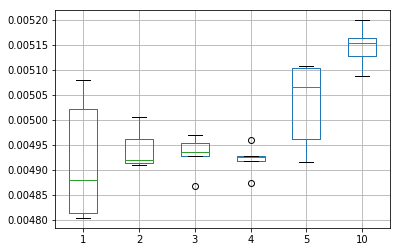

In [64]:
# run a repeated experiment
def experiment(repeats, series, neurons):
    series = dataset
    raw_values = series.values
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(raw_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-540], supervised_values[-540:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(repeats):
        # fit the model
        batch_size = 1
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, 10, 20, neurons)
        # forecast the entire training dataset to build up state for forecasting
        train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
        lstm_model.predict(train_reshaped, batch_size=10)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=10)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-540:], predictions))
        print('%d) Test RMSE: %.5f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores
 
# load dataset
series = dataset
# experiment
repeats = 5
results = DataFrame()
# vary neurons
neurons = [1, 2, 3, 4, 5, 10]
for n in neurons:
    results[str(n)] = experiment(repeats, series, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_neurons.png')

In [95]:
# I go for the 4 neurons due to much lower std compared to 1

In [4]:
# Epoch = 20
# Batch Size = 10
# Number of Neurons = 4

# Adding Layers

0) TrainRMSE=0.012652, TestRMSE=0.011596
1) TrainRMSE=0.012712, TestRMSE=0.011742
2) TrainRMSE=0.012479, TestRMSE=0.011275
3) TrainRMSE=0.012963, TestRMSE=0.011290
4) TrainRMSE=0.012731, TestRMSE=0.011401
5) TrainRMSE=0.012802, TestRMSE=0.011685
6) TrainRMSE=0.012470, TestRMSE=0.011397
7) TrainRMSE=0.012469, TestRMSE=0.011364
8) TrainRMSE=0.012690, TestRMSE=0.011661
9) TrainRMSE=0.012044, TestRMSE=0.011065


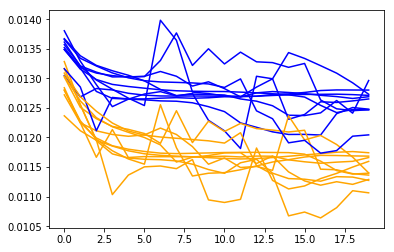

In [13]:
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare model
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit model
    train_rmse, test_rmse = list(), list()
    for i in range(nb_epoch):
        model.fit(X, y, epochs=20, batch_size=10, verbose=0, shuffle=False)
        model.reset_states()
        # evaluate model on train data
        raw_train = raw[-(len(train)+len(test)+1):-len(test)]
        train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
        model.reset_states()
        # evaluate model on test data
        raw_test = raw[-(len(test)+1):]
        test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
        model.reset_states()
    history = DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
    return history

def run():
    series = dataset
    raw_values = series.values
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(raw_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    train, test = supervised_values[0:-540], supervised_values[-540:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # fit and evaluate model
    train_trimmed = train_scaled[2:, :]
    # config
    repeats = 10
    n_batch = 10
    n_epochs = 20
    n_neurons = 4
    # run diagnostic tests
    for i in range(repeats):
        history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
        pyplot.plot(history['train'], color='blue')
        pyplot.plot(history['test'], color='orange')
        print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
    pyplot.savefig('layers_diagnostic.png')

# entry point
run()